In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [36]:
data = np.genfromtxt('Data/poker_hand/poker-hand-training-true.data', delimiter = ',')
np.shape(data)

(25010, 11)

In [37]:
data2 = np.genfromtxt('Data/poker_hand/poker-hand-testing.data', delimiter = ',')
np.shape(data2)

(1000000, 11)

In [39]:
total_data = np.concatenate([data, data2], axis=0)
np.shape(total_data)

(1025010, 11)

In [40]:
X, Y = np.split(total_data, np.array([10]), axis = 1)
print(np.shape(X))
Y = np.squeeze(Y)
print(np.shape(Y))

(1025010, 10)
(1025010,)


In [50]:
X_df

,0,1,2,3,4,5,6,7,8,9
0,1.0,10.0,1.0,11.0,1.0,13.0,1.0,12.0,1.0,1.0
1,2.0,11.0,2.0,13.0,2.0,10.0,2.0,12.0,2.0,1.0
2,3.0,12.0,3.0,11.0,3.0,13.0,3.0,10.0,3.0,1.0
3,4.0,10.0,4.0,11.0,4.0,1.0,4.0,13.0,4.0,12.0
4,4.0,1.0,4.0,13.0,4.0,12.0,4.0,11.0,4.0,10.0
...,...,...,...,...,...,...,...,...,...,...
1025005,3.0,1.0,1.0,12.0,2.0,9.0,4.0,9.0,2.0,6.0
1025006,3.0,3.0,4.0,5.0,2.0,7.0,1.0,4.0,4.0,3.0
1025007,1.0,11.0,4.0,7.0,3.0,9.0,1.0,13.0,2.0,7.0
1025008,3.0,11.0,1.0,8.0,1.0,1.0,3.0,13.0,2.0,8.0


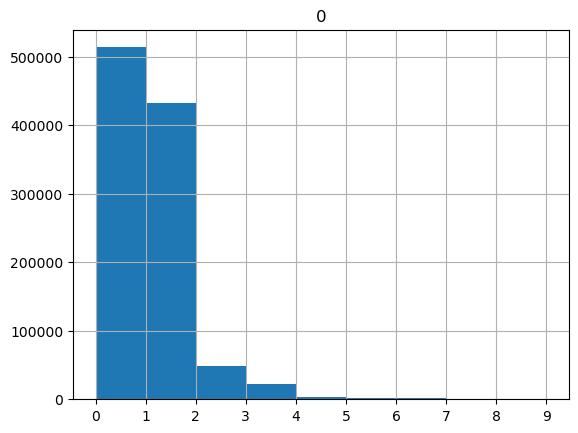

In [48]:
X_df = pd.DataFrame(X)
Y_df = pd.DataFrame(Y)
Y_df.hist(bins=range(0,10))
plt.xticks(range(0,10))
plt.show()

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class miniRnn(nn.Module):
    def __init__(self):
        super(miniRnn, self).__init__()
        self.fc1 = nn.Linear(10, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

base_model = miniRnn()

In [24]:
# CRIT = nn.CrossEntropyLoss()
# OPT = optim.Adam(base_model.parameters(), lr = 0.001)

In [43]:
from sklearn.model_selection import train_test_split

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(Y, dtype=torch.long)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)


In [44]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        true_pred = 0
        total_pred = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad() # Zeroing the gradients

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Track the loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            true_pred += (predicted == labels).sum().item()
            total_pred += labels.size(0)
        
        train_acc = true_pred / total_pred
        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {running_loss/len(train_loader)}, Train Acc: {train_acc * 100:.2f}%")

        validate_model(model, val_loader, criterion)

def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    true_pred = 0
    total_pred = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            true_pred += (predicted == labels).sum().item()
            total_pred += labels.size(0)
    
    val_acc = true_pred / total_pred
    print(f"validation Loss: {val_loss/len(val_loader)}, Validation Acc: {val_acc * 100:.2f}%")

In [45]:
train_model(model=base_model, train_loader=train_loader, val_loader=val_loader, criterion=nn.CrossEntropyLoss(), optimizer=optim.Adam(base_model.parameters(), lr = 0.01), epochs = 30)

Epoch [1/30], Train Loss: 0.9239132476431661, Train Acc: 56.54%
validation Loss: 0.8809878840279788, Validation Acc: 59.90%
Epoch [2/30], Train Loss: 0.8980765678671775, Train Acc: 58.38%
validation Loss: 0.8385666909252064, Validation Acc: 62.89%
Epoch [3/30], Train Loss: 0.8886584201480934, Train Acc: 59.02%
validation Loss: 0.8253336007824253, Validation Acc: 64.20%
Epoch [4/30], Train Loss: 0.8843196633827265, Train Acc: 59.26%


KeyboardInterrupt: 

## Improved Data Quality

In [51]:
import numpy as np
from collections import defaultdict

# Define mapping for card values and suits
card_value_map = {'A': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 
                  'T': 10, 'J': 11, 'Q': 12, 'K': 13}
suit_map = {'h': 1, 's': 2, 'd': 3, 'c': 4}

class_map = {'Pair': 1, 'Two Pair': 2, 'Three of a Kind': 3, 'Straight': 4, 
             'Straight (Wheel)': 4, 'Flush': 5, 'Full House': 6,
             'Four of a Kind': 7, 'Straight Flush': 8, 'Straight Flush (Wheel)': 8,
             'Royal Flush': 9, 'High Card': 0}

# Define the number of entries needed per class
entries_per_class = 10000  # Example: Adjust this to your need (1 million per class)
classes = ['Pair', 'High Card', 'Two Pair', 'Straight']  # Extend this with other classes
class_count = defaultdict(int)

# Initialize an empty list to hold data
data = []

def process_line(line):
    # Split the line by '->' to separate cards and class
    _, hand_info = line.strip().split('->')
    
    # Get the cards and the class (trim spaces)
    cards = hand_info.split(',')[0].strip()
    hand_class = hand_info.split(',')[1].strip()
    hand_class = class_map[hand_class]
    # If the class count is already full, skip
    if class_count[hand_class] >= entries_per_class:
        return None
    
    # Process the cards into numerical form
    card_array = []
    for card in cards.split():
        value = card_value_map[card[0]]
        suit = suit_map[card[1]]
        card_array.append([suit, value])
    
    # Flatten the card_array and append the class to it
    card_array_flat = [item for sublist in card_array for item in sublist]
    
    # Add the class string at the end
    card_array_flat.append(hand_class)
    
    # Increment the class count
    class_count[hand_class] += 1
    
    return card_array_flat

def process_file(filename):
    with open(filename, 'r') as file:
        for line in file:
            processed = process_line(line)
            if processed:
                data.append(processed)
            # Stop if we've collected enough entries for each class
            if all(count >= entries_per_class for count in class_count.values()):
                break


In [52]:
# Filepath for your text file
filename = 'Data/poker_hand/poker_hands_10m.txt'

# Process the file
process_file(filename)

# Convert to numpy array (ignoring the class labels for now)
data_array = np.array(data)
np.shape(data_array)

(83146, 11)

(83146, 10)
(83146,)


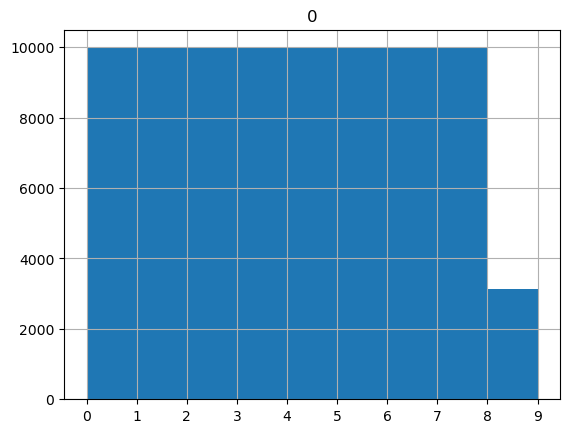

In [57]:
X, y = np.split(data_array, np.array([10]), axis = 1)
print(np.shape(X))
y = np.squeeze(y)
print(np.shape(y))
y_df = pd.DataFrame(y)
y_df.hist(bins = range(0, 10))
plt.xticks(range(0, 10))
plt.show()

In [58]:
from sklearn.model_selection import train_test_split

Xt = torch.tensor(X, dtype=torch.float32)
yt = torch.tensor(y, dtype=torch.long)

X_train, X_val, y_train, y_val = train_test_split(Xt, yt, test_size=0.2, random_state=42)
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)


In [59]:
train_model(model=base_model, train_loader=train_loader, val_loader=val_loader, criterion=nn.CrossEntropyLoss(), optimizer=optim.Adam(base_model.parameters(), lr = 0.01), epochs = 30)

Epoch [1/30], Train Loss: 0.8655828668807561, Train Acc: 71.20%
validation Loss: 0.3738898421709354, Validation Acc: 85.57%
Epoch [2/30], Train Loss: 0.5213040132791951, Train Acc: 80.03%
validation Loss: 0.33007439678678147, Validation Acc: 87.91%
Epoch [3/30], Train Loss: 0.4647174374272044, Train Acc: 81.98%
validation Loss: 0.2839106183212537, Validation Acc: 88.72%
Epoch [4/30], Train Loss: 0.4359712728800682, Train Acc: 83.00%
validation Loss: 0.3230514363600658, Validation Acc: 87.23%
Epoch [5/30], Train Loss: 0.41179428278253627, Train Acc: 83.83%
validation Loss: 0.24667163972671216, Validation Acc: 90.19%
Epoch [6/30], Train Loss: 0.38096536534050335, Train Acc: 84.99%
validation Loss: 0.24880285414938744, Validation Acc: 90.05%
Epoch [7/30], Train Loss: 0.36533324715609733, Train Acc: 85.71%
validation Loss: 0.2306813833805231, Validation Acc: 90.91%
Epoch [8/30], Train Loss: 0.3468276178106092, Train Acc: 86.40%
validation Loss: 0.229484302808459, Validation Acc: 91.37%
Epo